In [6]:
"""This script has following capabilities:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import shutil
import re

from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from scipy.interpolate import make_interp_spline
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [7]:
def read_file(filename, skiplines):
    with open(filename) as file:
        lines = file.readlines()
        total_lines = len(lines)
#         print('Total lines:', total_lines)

    # Read the data:
    rlines = lines[skiplines:]
    # Extract data from file
    data = np.array([list(map(float, line.strip().split())) for line in rlines])
#     print("Shape of data:", data.shape)
    header = lines[skiplines-1].strip().split()
    dt = data[1][0] - data[0][0]; # Time interval between data
    return header, dt, data

def normalize(arr, dt, Eq_time):
    """For a given array of time VACFx, y, z, and total
    this function normalizes the VACF data
    Useful for Au and Tilted polyethylene """
    Header = ['Time', 'VACFx', 'VACFy', 'VACFz', 'VACF']
    pd_data = pd.DataFrame(arr, columns =Header)
    pd_data['Time'] = pd_data['Time']*dt - Eq_time
#     pd_data['VACFx'] = pd_data['VACFx']/pd_data['VACF'][0]
#     pd_data['VACFy'] = pd_data['VACFy']/pd_data['VACF'][0]
#     pd_data['VACFz'] = pd_data['VACFz']/pd_data['VACF'][0]
#     pd_data['VACF'] = pd_data['VACF']/pd_data['VACF'][0]
    return pd_data

def normalizeAu_MNL(arr, dt, Eq_time):
    """For a given array of time VACFx, y, z, and total
    this function normalizes the VACF data
    Useful for Au and Tilted polyethylene """
    
    Header = ['Time', 'Au_VACFx', 'Au_VACFy', 'Au_VACFz', 'Au_VACF', 'MNL_VACFx', 'MNL_VACFy', 'MNL_VACFz', 'MNL_VACF']
    pd_data = pd.DataFrame(arr, columns =Header)
    pd_data['Time'] = pd_data['Time']*dt - Eq_time
    
    pd_data['Au_VACFx'] = pd_data['Au_VACFx']/pd_data['Au_VACF'][0]
    pd_data['Au_VACFy'] = pd_data['Au_VACFy']/pd_data['Au_VACF'][0]
    pd_data['Au_VACFz'] = pd_data['Au_VACFz']/pd_data['Au_VACF'][0]
    pd_data['Au_VACF'] = pd_data['Au_VACF']/pd_data['Au_VACF'][0]
    
    pd_data['MNL_VACFx'] = pd_data['MNL_VACFx']/pd_data['MNL_VACF'][0]
    pd_data['MNL_VACFy'] = pd_data['MNL_VACFy']/pd_data['MNL_VACF'][0]
    pd_data['MNL_VACFz'] = pd_data['MNL_VACFz']/pd_data['MNL_VACF'][0]
    pd_data['MNL_VACF'] = pd_data['MNL_VACF']/pd_data['MNL_VACF'][0]
    
    return pd_data

def VDOS(time, VACF, moving_avg, peak_percentage):
    """
    VACF = 1D Velocity autocorrelation function data
    time = time data in ps
    moving_avg = Moving average value
    peak_percentage = While looking for peaks this % of maximum peak height is considered as peak.
    """
    time_step = time[1] - time[0]
    
    # Compute the FFT.
    fft_result = np.fft.fft(VACF)

    # Compute the power spectrum.
    power_spectrum = np.abs(fft_result)**2

    # Compute the corresponding frequencies for each FFT bin.
    frequencies = np.fft.fftfreq(len(VACF), time_step)

    # Plot the power spectrum vs frequency.
    mask = frequencies >= 0  # only consider the positive frequencies

    freq_new = frequencies[mask]
    power_spectrum = power_spectrum[mask]
    normalizer1 = np.max(power_spectrum)

    # computing the peak magnitude and peak position:
    peak_threshold = np.max(power_spectrum) * peak_percentage/100  # for example, half of the maximum value
    peaks, _ = find_peaks(power_spectrum, height=peak_threshold)
    peak_freq = frequencies[peaks]
    peak_freq_mag = power_spectrum[peaks]    #/np.max(power_spectrum)
    
    return normalizer1, freq_new, power_spectrum, peak_freq, peak_freq_mag

def non_zero_col(df, ref_col):
    """
    df = name of the dataframe
    ref_col = reference used to select non-zero data
    """
    new_df = df.loc[df.iloc[:, ref_col] !=0]
    return new_df

In [35]:
# Loading the file containing VACF_data_info.dat
with open('./Frequency_analysis/VACF_data_info.dat') as file:
    lines = file.readlines()
    header = lines[0].strip().split()
#     print(header)
    k_num_jid = np.array([list(map(float, line.strip().split())) for line in lines[1:]])

k_arr = k_num_jid[:, 0].astype(int);         # K number 
lamda_arr = k_num_jid[:, 1];                 # Wavelength
freq_arr = k_num_jid[:, 2];                  # LA frequency, # "{:.2f}".format(freq_arr[6])
jid=k_num_jid[:, 3].astype(int)              # job id
VACF_time_arr = k_num_jid[:, 4].astype(int)  # Time in ps before VACF

print('Total no. of frequency points:', freq_arr.shape[0])

Total no. of frequency points: 1


68


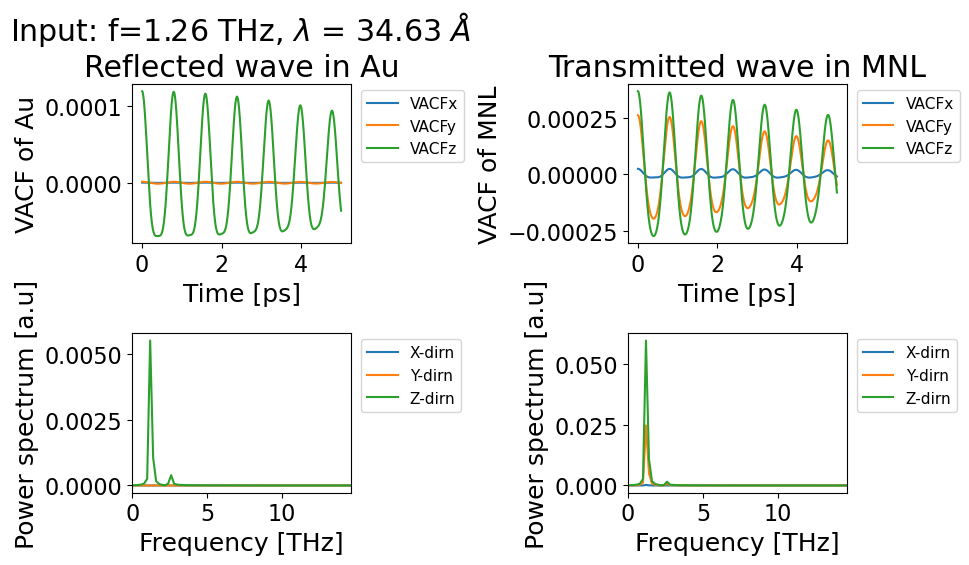

In [36]:
# np.set_printoptions(formatter={'all': '{:.2e}'.format})   # Sets print option for all

Md_dt = 0.00025              # timestep ps
d_steps = 10                 # steps between data
peak = 1                     # 1 means 1%         

# Making the folder:
dir_path = f'./Frequency_analysis/{peak}%_peak'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
# Empty lists to append peak magnitude and their magnitudes:
lamda_Au_x = []; lamda_Au_y = [] ; lamda_Au_z = []
lamda_MNL_X = []; lamda_MNL_Y = []; lamda_MNL_Z = []
Peak_mag_Au_x = []; Peak_mag_Au_y = []; Peak_mag_Au_z = []
Peak_mag_MNL_X = []; Peak_mag_MNL_Y = []; Peak_mag_MNL_Z = []

# Reading the data:
for i in np.arange(len(jid)):

    print(k_arr[i])
    MNL_file = f'./Extracted_VACF_data/VACF_data/VACF_{k_arr[i]}-lamda_{"{:.2f}".format(lamda_arr[i])}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}-MNL.dat'
    Au_file = f'./Extracted_VACF_data/VACF_data/VACF_{k_arr[i]}-lamda_{"{:.2f}".format(lamda_arr[i])}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}-Au.dat'
    
    
    # Read Au data:
    header, dt,  globals()[f'VACF_Au_k_num_{k_arr[i]}'] = read_file(Au_file, 2)
    # Normalize Au VACF data by VACF total
    globals()[f'VACF_Au_k_num_{k_arr[i]}'] = normalize(globals()[f'VACF_Au_k_num_{k_arr[i]}'], 
                                                       Md_dt, VACF_time_arr[i])
    
    
    # Read MNL data:
    header, dt,  globals()[f'VACF_MNL_k_num_{k_arr[i]}'] = read_file(MNL_file, 2) 
    # Normalize Au VACF data by VACF total
    globals()[f'VACF_MNL_k_num_{k_arr[i]}'] = normalize(globals()[f'VACF_MNL_k_num_{k_arr[i]}'], 
                                                       Md_dt, VACF_time_arr[i])
    fig, axs = plt.subplots(2,2, figsize=(10,6))
    # plotting the Reflected and Transmitted VACF and power spectrum:
    
    #VACF of Au:
    axs[0, 0].plot(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFx'], label='VACFx')
    axs[0, 0].plot(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFy'], label='VACFy')
    axs[0, 0].plot(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFz'], label='VACFz')
    axs[0, 0].set_xlabel(f'Time [ps]')
    axs[0, 0].set_ylabel(f'VACF of Au')
    axs[0, 0].set_title(f'Input: f={freq_arr[i]} THz, $\lambda$ = {lamda_arr[i]} $\AA$ \nReflected wave in Au')
    axs[0, 0].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
        
    #VACF of MNL
    axs[0, 1].plot(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFx'], label='VACFx')
    axs[0, 1].plot(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFy'], label='VACFy')
    axs[0, 1].plot(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFz'], label='VACFz')
    axs[0, 1].set_xlabel(f'Time [ps]')
    axs[0, 1].set_ylabel(f'VACF of MNL')
    axs[0, 1].set_title('Transmitted wave in MNL')
    axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    #Power spectrum of Au:
    normx, Au_freqx, Au_vdosx, fx, mx = VDOS(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFx'], 1, peak)
    normy, Au_freqy, Au_vdosy, fy, my = VDOS(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFy'], 1, peak)
    normz, Au_freqz, Au_vdosz, fz, mz = VDOS(globals()[f'VACF_Au_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_Au_k_num_{k_arr[i]}']['VACFz'], 1, peak)
    
    Au_freq = [fx, fy, fz]
    
    mAu = np.max([normx, normy, normz])
    
    axs[1, 0].plot(Au_freqx, Au_vdosx, label='X-dirn')
    axs[1, 0].plot(Au_freqy, Au_vdosy, label='Y-dirn')
    axs[1, 0].plot(Au_freqz, Au_vdosz, label='Z-dirn')
    
    # Save the data:
    
#     axs[1, 0].text(np.max(fz) + 3, 0.9, f'fx:{np.round(np.max(fx), 2)} THz, y={np.round(normx/mAu,2)}')
#     axs[1, 0].text(np.max(fz) + 3, 0.8, f'fy:{np.round(np.max(fy), 2)} THz, y={np.round(normy/mAu,2)}')
#     axs[1, 0].text(np.max(fz) + 3, 0.7, f'fz:{np.round(np.max(fz), 2)} THz, y={np.round(normz/mAu, 2)}')
    axs[1, 0].set_xlabel(f'Frequency [THz]')
    axs[1, 0].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 0].set_xlim(0, np.max(fz)+12)
    axs[1, 0].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    #Power spectrum of MNL:
    Normx, MNL_freqx, MNL_vdosx, Fx, Mx = VDOS(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFx'], 1, peak)
    Normy, MNL_freqy, MNL_vdosy, Fy, My = VDOS(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFy'], 1, peak)
    Normz, MNL_freqz, MNL_vdosz, Fz, Mz = VDOS(globals()[f'VACF_MNL_k_num_{k_arr[i]}']['Time'], globals()[f'VACF_MNL_k_num_{k_arr[i]}']['VACFz'], 1, peak)
    
    mMNL = np.max([Normx, Normy, Normz])
    
    axs[1, 1].plot(MNL_freqx, MNL_vdosx, label='X-dirn')
    axs[1, 1].plot(MNL_freqy, MNL_vdosy, label='Y-dirn')
    axs[1, 1].plot(MNL_freqz, MNL_vdosz, label='Z-dirn')
    
#     axs[1, 1].text(np.max(Fz) + 3, 0.9, f'fx:{np.round(np.max(Fx), 2)} THz, y={np.round(Normx/mMNL,2)}')
#     axs[1, 1].text(np.max(Fz) + 3, 0.8, f'fy:{np.round(np.max(Fy), 2)} THz, y={np.round(Normy/mMNL,2)}')
#     axs[1, 1].text(np.max(Fz) + 3, 0.7, f'fz:{np.round(np.max(Fz), 2)} THz, y={np.round(Normz/mMNL, 2)}')
    axs[1, 1].set_xlabel(f'Frequency [THz]')
    axs[1, 1].set_ylabel(f'Power spectrum [a.u]')
    axs[1, 1].set_xlim(0, np.max(Fz)+12)
    axs[1, 1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
    
    plt.tight_layout()
    plt.savefig(f'./Frequency_analysis//{peak}%_peak/VACF_plot_{k_arr[i]}-lamda_{lamda_arr[i]}-freq_{"{:.2f}".format(freq_arr[i])}-jid_{jid[i]}.png', dpi= 100, bbox_inches = 'tight', facecolor="w")
    plt.show()

In [37]:
np.savetxt('./Frequency_analysis/Au_power_spectrum_1.26THz.dat', np.vstack((Au_freqx, Au_freqy, Au_freqz, Au_vdosx, Au_vdosy, Au_vdosz)).T)